In [1]:
#TPU 초기화
import tensorflow as tf
import os

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])

tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

In [2]:
#TPU Strategy 셋팅
strategy = tf.distribute.TPUStrategy(resolver)

In [3]:
#create_model() 함수 만들기
def create_model():
  return tf.keras.Sequential(
      [tf.keras.layers.Conv2D(256, 3, activation='relu', input_shape=(28, 28, 1)),
       tf.keras.layers.Conv2D(256, 3, activation='relu'),
       tf.keras.layers.Flatten(),
       tf.keras.layers.Dense(256, activation='relu'),
       tf.keras.layers.Dense(128, activation='relu'),
       tf.keras.layers.Dense(10)])

In [4]:
with strategy.scope():
  model = create_model()
  model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['sparse_categorical_accuracy'])

##KoBERT를 이용한 네이버 영화 리뷰 분류하기

In [5]:
!pip install transformers

In [6]:
import transformers
transformers.__version__

'4.34.0'

In [7]:
import pandas as pd
import numpy as np
import urllib.request
import os
from tqdm import tqdm
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel

In [8]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7ae4d84f51b0>)

In [9]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [10]:
print('훈련용 리뷰 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력

훈련용 리뷰 개수 : 150000


In [11]:
print('테스트용 리뷰 개수 :',len(test_data)) # 테스트용 리뷰 개수 출력

테스트용 리뷰 개수 : 50000


In [12]:
train_data[:5] # 상위 5개 출력

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [13]:
test_data[:5] # 상위 5개 출력

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [14]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
train_data = train_data.reset_index(drop=True)
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [15]:
test_data = test_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
test_data = test_data.reset_index(drop=True)
print(test_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [16]:
print(len(train_data))

149995


In [17]:
print(len(test_data))

49997


In [18]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

In [19]:
print(tokenizer.encode("보는내내 그대로 들어맞는 예측 카리스마 없는 악역"))

[101, 9356, 11018, 31605, 31605, 110589, 71568, 118913, 11018, 9576, 119281, 9786, 79940, 23811, 40364, 9520, 23160, 102]


In [20]:
print(tokenizer.tokenize("보는내내 그대로 들어맞는 예측 카리스마 없는 악역"))

['보', '##는', '##내', '##내', '그대로', '들어', '##맞', '##는', '예', '##측', '카', '##리스', '##마', '없는', '악', '##역']


In [21]:
tokenizer.decode(tokenizer.encode("보는내내 그대로 들어맞는 예측 카리스마 없는 악역"))

'[CLS] 보는내내 그대로 들어맞는 예측 카리스마 없는 악역 [SEP]'

In [22]:
for elem in tokenizer.encode("보는내내 그대로 들어맞는 예측 카리스마 없는 악역"):
  print(tokenizer.decode(elem))

[ C L S ]
보
# # 는
# # 내
# # 내
그 대 로
들 어
# # 맞
# # 는
예
# # 측
카
# # 리 스
# # 마
없 는
악
# # 역
[ S E P ]


In [23]:
print(tokenizer.tokenize("전율을 일으키는 영화. 다시 보고싶은 영화"))

['전', '##율', '##을', '일', '##으', '##키는', '영화', '.', '다시', '보고', '##싶', '##은', '영화']


In [24]:
print(tokenizer.encode("전율을 일으키는 영화. 다시 보고싶은 영화"))

[101, 9665, 119183, 10622, 9641, 119185, 66815, 42428, 119, 25805, 98199, 119088, 10892, 42428, 102]


In [25]:
for elem in tokenizer.encode("전율을 일으키는 영화. 다시 보고싶은 영화"):
  print(tokenizer.decode(elem))

[ C L S ]
전
# # 율
# # 을
일
# # 으
# # 키 는
영 화
.
다 시
보 고
# # 싶
# # 은
영 화
[ S E P ]


In [26]:
for elem in tokenizer.encode("happy birthday~!"):
  print(tokenizer.decode(elem))

[ C L S ]
h a p p y
b i r t h d a y
~
!
[ S E P ]


In [27]:
print(tokenizer.decode(101))

[ C L S ]


In [28]:
print(tokenizer.decode(102))

[ S E P ]


In [29]:
print(tokenizer.cls_token, ':', tokenizer.cls_token_id)
print(tokenizer.sep_token, ':' , tokenizer.sep_token_id)

[CLS] : 101
[SEP] : 102


In [30]:
print(tokenizer.pad_token, ':', tokenizer.pad_token_id)

[PAD] : 0


In [31]:
max_seq_len = 128

In [32]:
encoded_result = tokenizer.encode("전율을 일으키는 영화. 다시 보고싶은 영화", max_length=max_seq_len, pad_to_max_length=True)
print(encoded_result)
print('길이 :', len(encoded_result))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


[101, 9665, 119183, 10622, 9641, 119185, 66815, 42428, 119, 25805, 98199, 119088, 10892, 42428, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
길이 : 128


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2622: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [33]:
#세그멘트 인풋
print([0]*max_seq_len)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [34]:
#마스크 인풋
valid_num = len(tokenizer.encode("전율을 일으키는 영화. 다시 보고싶은 영화"))
print(valid_num * [1] + (max_seq_len - valid_num) * [0])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [35]:
def convert_examples_to_features(examples, labels, max_seq_len, tokenizer):

    input_ids, attention_masks, token_type_ids, data_labels = [], [], [], []

    for example, label in tqdm(zip(examples, labels), total=len(examples)):
        # input_id는 워드 임베딩을 위한 문장의 정수 인코딩
        input_id = tokenizer.encode(example, max_length=max_seq_len, pad_to_max_length=True)

        # attention_mask는 실제 단어가 위치하면 1, 패딩의 위치에는 0인 시퀀스.
        padding_count = input_id.count(tokenizer.pad_token_id)
        attention_mask = [1] * (max_seq_len - padding_count) + [0] * padding_count

        # token_type_id는 세그먼트 임베딩을 위한 것으로 이번 예제는 문장이 1개이므로 전부 0으로 통일.
        token_type_id = [0] * max_seq_len

        assert len(input_id) == max_seq_len, "Error with input length {} vs {}".format(len(input_id), max_seq_len)
        assert len(attention_mask) == max_seq_len, "Error with attention mask length {} vs {}".format(len(attention_mask), max_seq_len)
        assert len(token_type_id) == max_seq_len, "Error with token type length {} vs {}".format(len(token_type_id), max_seq_len)

        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        data_labels.append(label)

    input_ids = np.array(input_ids, dtype=int)
    attention_masks = np.array(attention_masks, dtype=int)
    token_type_ids = np.array(token_type_ids, dtype=int)

    data_labels = np.asarray(data_labels, dtype=np.int32)

    return (input_ids, attention_masks, token_type_ids), data_labels

In [36]:
train_X, train_y = convert_examples_to_features(train_data['document'], train_data['label'], max_seq_len=max_seq_len, tokenizer=tokenizer)

100%|██████████| 149995/149995 [01:44<00:00, 1441.28it/s]


In [37]:
test_X, test_y = convert_examples_to_features(test_data['document'], test_data['label'], max_seq_len=max_seq_len, tokenizer=tokenizer)

100%|██████████| 49997/49997 [00:26<00:00, 1885.35it/s]


In [38]:
# 최대 길이: 128
input_id = train_X[0][0]
attention_mask = train_X[1][0]
token_type_id = train_X[2][0]
label = train_y[0]

print('단어에 대한 정수 인코딩 :',input_id)
print('어텐션 마스크 :',attention_mask)
print('세그먼트 인코딩 :',token_type_id)
print('각 인코딩의 길이 :', len(input_id))
print('정수 인코딩 복원 :',tokenizer.decode(input_id))
print('레이블 :',label)

단어에 대한 정수 인코딩 : [   101   9519   9074 119005    119    119   9708 119235   9715 119230
  16439  77884  48549   9284  22333  12692    102      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0]
어텐션 마스크 : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [39]:
model = TFBertModel.from_pretrained("bert-base-multilingual-cased")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [40]:
max_seq_len = 128

In [41]:
input_ids_layer = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32)
attention_masks_layer = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32)
token_type_ids_layer = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32)

outputs = model([input_ids_layer, attention_masks_layer, token_type_ids_layer])

In [42]:
print(outputs)

TFBaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=<KerasTensor: shape=(None, 128, 768) dtype=float32 (created by layer 'tf_bert_model')>, pooler_output=<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'tf_bert_model')>, past_key_values=None, hidden_states=None, attentions=None, cross_attentions=None)


In [43]:
print(outputs[0])

KerasTensor(type_spec=TensorSpec(shape=(None, 128, 768), dtype=tf.float32, name=None), name='tf_bert_model/bert/encoder/layer_._11/output/LayerNorm/batchnorm/add_1:0', description="created by layer 'tf_bert_model'")


In [44]:
print(outputs[1])

KerasTensor(type_spec=TensorSpec(shape=(None, 768), dtype=tf.float32, name=None), name='tf_bert_model/bert/pooler/dense/Tanh:0', description="created by layer 'tf_bert_model'")


In [45]:
class TFBertForSequenceClassification(tf.keras.Model):
    def __init__(self, model_name):
        super(TFBertForSequenceClassification, self).__init__()
        self.bert = TFBertModel.from_pretrained(model_name, from_pt=True)
        self.classifier = tf.keras.layers.Dense(1,
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(0.02),
                                                activation='sigmoid',
                                                name='classifier')

    def call(self, inputs):
        input_ids, attention_mask, token_type_ids = inputs
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        cls_token = outputs[1]
        prediction = self.classifier(cls_token)

        return prediction

In [46]:
#TPU 작동을 위한 코드 TPU 작동을 위한 코드
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

In [47]:
strategy = tf.distribute.experimental.TPUStrategy(resolver)

In [48]:
with strategy.scope():
  model = TFBertForSequenceClassification("bert-base-multilingual-cased")
  optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
  loss = tf.keras.losses.BinaryCrossentropy()
  model.compile(optimizer=optimizer, loss=loss, metrics = ['accuracy'])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

In [49]:
model.fit(train_X, train_y, epochs=2, batch_size=64, validation_split=0.2)

Epoch 1/2
1875/1875 [==============================] - 297s 127ms/step - loss: 0.3964 - accuracy: 0.8162 - val_loss: 0.3366 - val_accuracy: 0.8515
Epoch 2/2
1875/1875 [==============================] - 229s 122ms/step - loss: 0.3044 - accuracy: 0.8686 - val_loss: 0.3213 - val_accuracy: 0.8634


In [50]:
results = model.evaluate(test_X, test_y, batch_size=1024)
print("test loss, test acc: ", results)

49/49 [==============================] - 12s 228ms/step - loss: 0.3264 - accuracy: 0.8613
test loss, test acc:  [0.3264088034629822, 0.8612716794013977]


In [51]:
def sentiment_predict(new_sentence):
  input_id = tokenizer.encode(new_sentence, max_length=max_seq_len, pad_to_max_length=True)

  padding_count = input_id.count(tokenizer.pad_token_id)
  attention_mask = [1] * (max_seq_len - padding_count) + [0] * padding_count
  token_type_id = [0] * max_seq_len

  input_ids = np.array([input_id])
  attention_masks = np.array([attention_mask])
  token_type_ids = np.array([token_type_id])

  encoded_input = [input_ids, attention_masks, token_type_ids]
  score = model.predict(encoded_input)[0][0]
  print(score)

  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [52]:
sentiment_predict("보던거라 계속보고있는데 전개도 느리고 주인공인 은희는 한두컷 나오면서 소극적인모습에 ")

1/1 [==============================] - 6s 6s/step
0.48878518
51.12% 확률로 부정 리뷰입니다.



In [53]:
sentiment_predict("스토리는 확실히 실망이였지만 배우들 연기력이 대박이였다 특히 이제훈 연기 정말 ... 이 배우들로 이렇게밖에 만들지 못한 영화는 아쉽지만 배우들 연기력과 사운드는 정말 빛났던 영화. 기대하고 극장에서 보면 많이 실망했겠지만 평점보고 기대없이 집에서 편하게 보면 괜찮아요. 이제훈님 연기력은 최고인 것 같습니다")

1/1 [==============================] - 1s 642ms/step
0.99289906
99.29% 확률로 긍정 리뷰입니다.



In [54]:
sentiment_predict("별 똥같은 영화를 다 보네. 개별로입니다.")

1/1 [==============================] - 1s 845ms/step
0.013391465
98.66% 확률로 부정 리뷰입니다.



In [55]:
sentiment_predict("이 영화 존잼입니다 대박.")

1/1 [==============================] - 1s 798ms/step
0.96100247
96.10% 확률로 긍정 리뷰입니다.



In [56]:
sentiment_predict('이 영화 개꿀잼 ㅋㅋㅋ')

1/1 [==============================] - 1s 826ms/step
0.83418846
83.42% 확률로 긍정 리뷰입니다.



In [57]:
sentiment_predict('이딴게 영화냐 ㅉㅉ')

1/1 [==============================] - 1s 821ms/step
0.010350823
98.96% 확률로 부정 리뷰입니다.



In [58]:
sentiment_predict('감독 뭐하는 놈이냐?')

1/1 [==============================] - 2s 2s/step
0.02108413
97.89% 확률로 부정 리뷰입니다.



In [59]:
sentiment_predict('와 개쩐다 정말 세계관 최강자들의 영화다')

1/1 [==============================] - 1s 854ms/step
0.94342697
94.34% 확률로 긍정 리뷰입니다.



##TFBertForSequenceClassification

In [60]:
#데이터 전처리

In [61]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re
import urllib.request

In [62]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7ae4ae4b4bb0>)

In [63]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [64]:
print('훈련용 리뷰 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력

훈련용 리뷰 개수 : 150000


In [65]:
train_data[:5] # 상위 5개 출력

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [66]:
print('테스트용 리뷰 개수 :',len(test_data)) # 테스트용 리뷰 개수 출력

테스트용 리뷰 개수 : 50000


In [67]:
test_data[:5]

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [68]:
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

In [69]:
train_data.drop_duplicates(subset=['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거

In [70]:
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 146183


<Axes: >

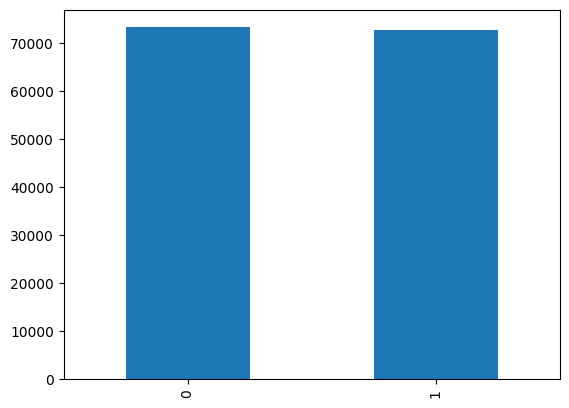

In [71]:
train_data['label'].value_counts().plot(kind = 'bar')

In [72]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  73342
1      1  72841


In [73]:
print(train_data.isnull().values.any())

True


In [74]:
print(train_data.isnull().sum())

id          0
document    1
label       0
dtype: int64


In [75]:
train_data.loc[train_data.document.isnull()]

,id,document,label
25857,2172111,NaN,1


In [76]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [77]:
print(len(train_data))

146182


In [78]:
#토크나이저를 이용한 정수 인코딩

In [79]:
import transformers
transformers.__version__

'4.34.0'

In [80]:
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained("klue/bert-base")

In [81]:
test_data = test_data.dropna(how = 'any')

In [82]:
print(len(test_data))

49997


In [83]:
X_train_list = train_data['document'].tolist()
X_test_list = test_data['document'].tolist()
y_train = train_data['label'].tolist()
y_test = test_data['label'].tolist()

In [84]:
X_train = tokenizer(X_train_list, truncation=True, padding=True)
X_test = tokenizer(X_test_list, truncation=True, padding=True)

In [85]:
print(X_train[0].tokens)

['[CLS]', '아', '더', '##빙', '.', '.', '진짜', '짜증', '##나', '##네', '##요', '목소리', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD

In [86]:
print(X_train[0].ids)

[2, 1376, 831, 2604, 18, 18, 4229, 9801, 2075, 2203, 2182, 4243, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [87]:
print(X_train[0].type_ids)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [88]:
print(X_train[0].attention_mask)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [89]:
#데이터셋 생성 및 모델 학습

In [90]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(X_train),
    y_train
))

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(X_test),
    y_test
))

In [91]:
from transformers import TFBertForSequenceClassification
from tensorflow.keras.callbacks import EarlyStopping

In [92]:
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)

In [93]:
model = TFBertForSequenceClassification.from_pretrained("klue/bert-base", num_labels=2, from_pt=True)
model.compile(optimizer=optimizer, loss=model.hf_compute_loss, metrics=['accuracy'])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [94]:
model.hf_compute_loss

<bound method TFSequenceClassificationLoss.hf_compute_loss of <transformers.models.bert.modeling_tf_bert.TFBertForSequenceClassification object at 0x7ae421fea800>>

In [95]:
callback_earlystop = EarlyStopping(
    monitor="val_accuracy",
    min_delta=0.001,
    patience=2)

model.fit(
    train_dataset.shuffle(10000).batch(32), epochs=1, batch_size=64,
    validation_data = val_dataset.shuffle(10000).batch(64),
    callbacks = [callback_earlystop]
)

 142/4569 [..............................] - ETA: 4:22:19 - loss: 0.4130 - accuracy: 0.8035

KeyboardInterrupt: ignored

In [ ]:
model.evaluate(val_dataset.batch(1024))

In [ ]:
#모델 저장

In [ ]:
model.save_pretrained('nsmc_model/bert-base')
tokenizer.save_pretrained('nsmc_model/bert-base')

In [ ]:
#모델 로드 및 테스트

In [ ]:
from transformers import TextClassificationPipeline

# 로드하기
loaded_tokenizer = BertTokenizerFast.from_pretrained('nsmc_model/bert-base')
loaded_model = TFBertForSequenceClassification.from_pretrained('nsmc_model/bert-base')

text_classifier = TextClassificationPipeline(
    tokenizer=loaded_tokenizer,
    model=loaded_model,
    framework='tf',
    return_all_scores=True
)

In [ ]:
test_data

In [ ]:
text_classifier('뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아')[0]

In [ ]:
text_classifier('오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함')[0]

##KoBERT를 이용한 KorNLI 풀어보기

In [96]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import urllib.request
from sklearn import preprocessing
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [97]:
#훈련 데이터 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/kakaobrain/KorNLUDatasets/master/KorNLI/multinli.train.ko.tsv", filename="multinli.train.ko.tsv")
urllib.request.urlretrieve("https://raw.githubusercontent.com/kakaobrain/KorNLUDatasets/master/KorNLI/snli_1.0_train.ko.tsv", filename="snli_1.0_train.ko.tsv")

('snli_1.0_train.ko.tsv', <http.client.HTTPMessage at 0x7ae419ee03a0>)

In [98]:
#검증 데이터 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/kakaobrain/KorNLUDatasets/master/KorNLI/xnli.dev.ko.tsv", filename="xnli.dev.ko.tsv")

('xnli.dev.ko.tsv', <http.client.HTTPMessage at 0x7ae419ee2a40>)

In [99]:
#테스트 데이터 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/kakaobrain/KorNLUDatasets/master/KorNLI/xnli.test.ko.tsv", filename="xnli.test.ko.tsv")

('xnli.test.ko.tsv', <http.client.HTTPMessage at 0x7ae419ee3eb0>)

In [100]:
train_snli = pd.read_csv("snli_1.0_train.ko.tsv", sep='\t', quoting=3)
train_xnli = pd.read_csv("multinli.train.ko.tsv", sep='\t', quoting=3)
val_data = pd.read_csv("xnli.dev.ko.tsv", sep='\t', quoting=3)
test_data = pd.read_csv("xnli.test.ko.tsv", sep='\t', quoting=3)

In [101]:
train_snli.head()

,sentence1,sentence2,gold_label
0,말을 탄 사람이 고장난 비행기 위로 뛰어오른다.,한 사람이 경쟁을 위해 말을 훈련시키고 있다.,neutral
1,말을 탄 사람이 고장난 비행기 위로 뛰어오른다.,한 사람이 식당에서 오믈렛을 주문하고 있다.,contradiction
2,말을 탄 사람이 고장난 비행기 위로 뛰어오른다.,사람은 야외에서 말을 타고 있다.,entailment
3,카메라에 웃고 손을 흔드는 아이들,그들은 부모님을 보고 웃고 있다,neutral
4,카메라에 웃고 손을 흔드는 아이들,아이들이 있다,entailment


In [102]:
train_xnli.head()

,sentence1,sentence2,gold_label
0,개념적으로 크림 스키밍은 제품과 지리라는 두 가지 기본 차원을 가지고 있다.,제품과 지리학은 크림 스키밍을 작동시키는 것이다.,neutral
1,시즌 중에 알고 있는 거 알아? 네 레벨에서 다음 레벨로 잃어버리는 거야 브레이브스...,사람들이 기억하면 다음 수준으로 물건을 잃는다.,entailment
2,우리 번호 중 하나가 당신의 지시를 세밀하게 수행할 것이다.,우리 팀의 일원이 당신의 명령을 엄청나게 정확하게 실행할 것이다.,entailment
3,어떻게 아세요? 이 모든 것이 다시 그들의 정보다.,이 정보는 그들의 것이다.,entailment
4,"그래, 만약 네가 테니스화 몇 개를 사러 간다면, 나는 왜 그들이 100달러대에서 ...",테니스화의 가격은 다양하다.,neutral


In [103]:
#결합 후 섞기
train_data = train_snli.append(train_xnli)
train_data = train_data.sample(frac=1)

<ipython-input-103-b02832063179>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_snli.append(train_xnli)


In [104]:
train_data.head()

,sentence1,sentence2,gold_label
307002,한 방에 있는 소파에 앉아 있는 두 남자.,두 남자가 소파에 앉아 텔레비전을 보고 있다.,neutral
257889,마이애미 농구 선수가 보고 있다.,농구선수는 경기를 관람하고 있다,neutral
299667,1830년대에 왕립 연구소로 처음 알려진 국립 미술관은 1946년 서덜랜드 공작의 ...,국립 미술관은 1946년 서덜랜드 공작으로부터 혜택을 받았다.,entailment
178931,모래길을 따라 주차된 차량의 뒷문 운전석 옆문을 여는 남자.,한 남자가 개를 내보내기 위해 차 뒷문을 연다.,neutral
198380,어린 소녀는 파란 모자를 쓰고 지저분한 간식을 먹는다.,이 사진에는 아이가 있습니다.,entailment


In [105]:
val_data.head()

,sentence1,sentence2,gold_label
0,"그리고 그가 말했다, ""엄마, 저 왔어요.""",그는 학교 버스가 그를 내려주자마자 엄마에게 전화를 걸었다.,neutral
1,"그리고 그가 말했다, ""엄마, 저 왔어요.""",그는 한마디도 하지 않았다.,contradiction
2,"그리고 그가 말했다, ""엄마, 저 왔어요.""",그는 엄마에게 집에 갔다고 말했다.,entailment
3,내가 무엇을 위해 가고 있는지 또는 어떤 것을 위해 있는지 몰랐기 때문에 워싱턴의 ...,나는 워싱턴에 가본 적이 없어서 거기 배정을 받았을 때 그 장소를 찾으려다가 길을 ...,neutral
4,내가 무엇을 위해 가고 있는지 또는 어떤 것을 위해 있는지 몰랐기 때문에 워싱턴의 ...,워싱턴으로 진군하면서 해야 할 일이 무엇인지 정확히 알고 있었다.,contradiction


In [106]:
test_data.head()

,sentence1,sentence2,gold_label
0,"글쎄, 나는 그것에 관해 생각조차 하지 않았지만, 나는 너무 좌절했고, 결국 그에게...",나는 그와 다시 이야기하지 않았다.,contradiction
1,"글쎄, 나는 그것에 관해 생각조차 하지 않았지만, 나는 너무 좌절했고, 결국 그에게...",나는 다시 그와 이야기를 하기 시작했다는 것에 너무 화가 났다.,entailment
2,"글쎄, 나는 그것에 관해 생각조차 하지 않았지만, 나는 너무 좌절했고, 결국 그에게...",우리는 좋은 대화를 나눴다.,neutral
3,"그리고 저는 그것이 특권이라고 생각했습니다, 그리고 여전히, 여전히, 당시 저는 A...",그날 현장에 나만 있었던 게 아니라는 걸 몰랐던 것이다.,neutral
4,"그리고 저는 그것이 특권이라고 생각했습니다, 그리고 여전히, 여전히, 당시 저는 A...",나는 AFFC 공군 경력 분야에서 그 번호를 가진 유일한 사람이라는 인상을 가지고 ...,entailment


In [107]:
def drop_na_and_duplciates(df):
  df = df.dropna()
  df = df.drop_duplicates()
  df = df.reset_index(drop=True)
  return df

In [108]:
#결측값 및 중복 샘플 제거
train_data = drop_na_and_duplciates(train_data)
val_data = drop_na_and_duplciates(val_data)
test_data = drop_na_and_duplciates(test_data)

In [109]:
train_data

,sentence1,sentence2,gold_label
0,한 방에 있는 소파에 앉아 있는 두 남자.,두 남자가 소파에 앉아 텔레비전을 보고 있다.,neutral
1,마이애미 농구 선수가 보고 있다.,농구선수는 경기를 관람하고 있다,neutral
2,1830년대에 왕립 연구소로 처음 알려진 국립 미술관은 1946년 서덜랜드 공작의 ...,국립 미술관은 1946년 서덜랜드 공작으로부터 혜택을 받았다.,entailment
3,모래길을 따라 주차된 차량의 뒷문 운전석 옆문을 여는 남자.,한 남자가 개를 내보내기 위해 차 뒷문을 연다.,neutral
4,어린 소녀는 파란 모자를 쓰고 지저분한 간식을 먹는다.,이 사진에는 아이가 있습니다.,entailment
...,...,...,...
941809,그들은 결코 그녀를 찾는 것을 멈추지 않을 것이라고 존은 말했다.,존은 그들이 그녀의 시체를 찾는 것을 멈추지 않을 것이라고 말했다.,neutral
941810,두 어린 소녀가 시멘트 계단에 앉아 식사를 하고 있다.,두 소녀는 계단에서 아이스크림을 먹고 있다.,entailment
941811,"어린 소년들, 교실에서, 일하고 있다.",어린 소년들이 있다,entailment
941812,핸드백을 든 남자가 입고 있는 스카프를 보고 있다.,옷을 검사하는 가방을 든 남자.,entailment


In [110]:
val_data

,sentence1,sentence2,gold_label
0,"그리고 그가 말했다, ""엄마, 저 왔어요.""",그는 학교 버스가 그를 내려주자마자 엄마에게 전화를 걸었다.,neutral
1,"그리고 그가 말했다, ""엄마, 저 왔어요.""",그는 한마디도 하지 않았다.,contradiction
2,"그리고 그가 말했다, ""엄마, 저 왔어요.""",그는 엄마에게 집에 갔다고 말했다.,entailment
3,내가 무엇을 위해 가고 있는지 또는 어떤 것을 위해 있는지 몰랐기 때문에 워싱턴의 ...,나는 워싱턴에 가본 적이 없어서 거기 배정을 받았을 때 그 장소를 찾으려다가 길을 ...,neutral
4,내가 무엇을 위해 가고 있는지 또는 어떤 것을 위해 있는지 몰랐기 때문에 워싱턴의 ...,워싱턴으로 진군하면서 해야 할 일이 무엇인지 정확히 알고 있었다.,contradiction
...,...,...,...
2485,피스티는 피즐처럼 중간 영어의 피스틴으로 시작되어 방귀를 뀌기 위해 주먹을 쥐었다.,Fiesty는 100년 동안 존재해 왔다.,neutral
2486,피스티는 피즐처럼 중간 영어의 피스틴으로 시작되어 방귀를 뀌기 위해 주먹을 쥐었다.,Fiesty는 주먹질과는 무관하다.,contradiction
2487,"진술이 더 나은 반면, 대답은 완성의 정신적 그림을 준다.",진술은 더 자세한 내용을 알려준다.,neutral
2488,"진술이 더 나은 반면, 대답은 완성의 정신적 그림을 준다.",진술이 더 나은 것은 아니다.,contradiction


In [111]:
test_data

,sentence1,sentence2,gold_label
0,"글쎄, 나는 그것에 관해 생각조차 하지 않았지만, 나는 너무 좌절했고, 결국 그에게...",나는 그와 다시 이야기하지 않았다.,contradiction
1,"글쎄, 나는 그것에 관해 생각조차 하지 않았지만, 나는 너무 좌절했고, 결국 그에게...",나는 다시 그와 이야기를 하기 시작했다는 것에 너무 화가 났다.,entailment
2,"글쎄, 나는 그것에 관해 생각조차 하지 않았지만, 나는 너무 좌절했고, 결국 그에게...",우리는 좋은 대화를 나눴다.,neutral
3,"그리고 저는 그것이 특권이라고 생각했습니다, 그리고 여전히, 여전히, 당시 저는 A...",그날 현장에 나만 있었던 게 아니라는 걸 몰랐던 것이다.,neutral
4,"그리고 저는 그것이 특권이라고 생각했습니다, 그리고 여전히, 여전히, 당시 저는 A...",나는 AFFC 공군 경력 분야에서 그 번호를 가진 유일한 사람이라는 인상을 가지고 ...,entailment
...,...,...,...
5005,데이비슨은 스콘의 발음을 '뼈'와 운을 맞추기 위해 채택해서는 안 된다. 어쨌든 그...,Davidson은 뼈와 스콘이 같은 소리를 내는 방식으로 말하면 안 된다.,entailment
5006,데이비슨은 스콘의 발음을 '뼈'와 운을 맞추기 위해 채택해서는 안 된다. 어쨌든 그...,Davidson이 스콘과 뼈라는 단어에 운율을 맞추는 편이 나을 것이다.,contradiction
5007,"25달러에 20만 단어의 평균 소설은 달러당 8,000단어로 적용된다.",25달러짜리 20만 단어 소설은 공정한 가격이다.,neutral
5008,"25달러에 20만 단어의 평균 소설은 달러당 8,000단어로 적용된다.",25달러짜리 20만 단어 소설은 달러당 4천 단어다.,contradiction


In [112]:
tokenizer = BertTokenizer.from_pretrained("klue/bert-base")

In [113]:
max_seq_len = 128

In [114]:
def convert_examples_to_features(sent_list1, sent_list2, max_seq_len, tokenizer):

    input_ids, attention_masks, token_type_ids = [], [], []

    for sent1, sent2 in tqdm(zip(sent_list1, sent_list2), total=len(sent_list1)):
        encoding_result = tokenizer.encode_plus(sent1, sent2, max_length=max_seq_len, pad_to_max_length=True)

        input_ids.append(encoding_result['input_ids'])
        attention_masks.append(encoding_result['attention_mask'])
        token_type_ids.append(encoding_result['token_type_ids'])

    input_ids = np.array(input_ids, dtype=int)
    attention_masks = np.array(attention_masks, dtype=int)
    token_type_ids = np.array(token_type_ids, dtype=int)

    return (input_ids, attention_masks, token_type_ids)

In [ ]:
X_train = convert_examples_to_features(train_data['sentence1'], train_data['sentence2'], max_seq_len=max_seq_len, tokenizer=tokenizer)

  0%|          | 0/941814 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2622: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Be aware, overflowing tokens are not returned for the set

In [1]:
#최대 길이: 128
input_id = X_train[0][0]
attention_mask = X_train[1][0]
token_type_id = X_train[2][0]

print('단어에 대한 정수 인코딩 :',input_id)
print('어텐션 마스크 :',attention_mask)
print('세그먼트 인코딩 :',token_type_id)
print('각 인코딩의 길이 :', len(input_id))
print('정수 인코딩 복원 :',tokenizer.decode(input_id))

NameError: ignored

In [2]:
X_val = convert_examples_to_features(val_data['sentence1'], val_data['sentence2'], max_seq_len=max_seq_len, tokenizer=tokenizer)

NameError: ignored

In [ ]:
#최대 길이: 128
input_id = X_val[0][0]
attention_mask = X_val[1][0]
token_type_id = X_val[2][0]

print('단어에 대한 정수 인코딩 :',input_id)
print('어텐션 마스크 :',attention_mask)
print('세그먼트 인코딩 :',token_type_id)
print('각 인코딩의 길이 :', len(input_id))
print('정수 인코딩 복원 :',tokenizer.decode(input_id))

In [ ]:
X_test = convert_examples_to_features(test_data['sentence1'], test_data['sentence2'], max_seq_len=max_seq_len, tokenizer=tokenizer)

In [ ]:
train_label = train_data['gold_label'].tolist()
val_label = val_data['gold_label'].tolist()
test_label = test_data['gold_label'].tolist()

In [ ]:
idx_encode = preprocessing.LabelEncoder()
idx_encode.fit(train_label)

y_train = idx_encode.transform(train_label) # 주어진 고유한 정수로 변환
y_val = idx_encode.transform(val_label) # 고유한 정수로 변환
y_test = idx_encode.transform(test_label) # 고유한 정수로 변환

label_idx = dict(zip(list(idx_encode.classes_), idx_encode.transform(list(idx_encode.classes_))))
idx_label = {value: key for key, value in label_idx.items()}
print(label_idx)
print(idx_label)

In [ ]:
from transformers import TFBertForSequenceClassification

In [ ]:
#TPU 작동을 위한 코드
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

In [ ]:
strategy = tf.distribute.experimental.TPUStrategy(resolver)

In [ ]:
with strategy.scope():
  model = TFBertForSequenceClassification.from_pretrained("klue/bert-base", num_labels=3, from_pt=True)
  optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
  model.compile(optimizer=optimizer, loss=model.hf_compute_loss, metrics = ['accuracy'])

In [3]:
early_stopping = EarlyStopping(
    monitor="val_accuracy",
    min_delta=0.001,
    patience=2)

model.fit(
    X_train, y_train, epochs=2, batch_size=32, validation_data = (X_val, y_val),
    callbacks = [early_stopping]
)

NameError: ignored

In [ ]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test, batch_size=1024)[1]))

##KoBERT를 이용한 개체명 인식

In [5]:
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 949.4 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=dfde0353cde2dac7bcc48c86b04455c95c618837783a0d05ffbc90d0ff451144
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [6]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from transformers import shape_list, BertTokenizer, TFBertModel
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from seqeval.metrics import f1_score, classification_report
import tensorflow as tf

In [7]:
#데이터 로드
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1jatBP8yZkWn6Kg6mjN7nWLnYVwXE_sY_' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1jatBP8yZkWn6Kg6mjN7nWLnYVwXE_sY_" -O ner_train_data.csv && rm -rf /tmp/cookies.txt

--2023-10-10 07:29:21--  https://docs.google.com/uc?export=download&confirm=&id=1jatBP8yZkWn6Kg6mjN7nWLnYVwXE_sY_
Resolving docs.google.com (docs.google.com)... 142.250.103.138, 142.250.103.100, 142.250.103.102, ...
Connecting to docs.google.com (docs.google.com)|142.250.103.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-7k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/s21ki74nml3jso2hbt4sl9hgj2jjqn88/1696922925000/17609157229046208934/*/1jatBP8yZkWn6Kg6mjN7nWLnYVwXE_sY_?e=download&uuid=eaf8557f-5a3d-4c06-9095-00d250b1261c [following]
--2023-10-10 07:29:22--  https://doc-00-7k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/s21ki74nml3jso2hbt4sl9hgj2jjqn88/1696922925000/17609157229046208934/*/1jatBP8yZkWn6Kg6mjN7nWLnYVwXE_sY_?e=download&uuid=eaf8557f-5a3d-4c06-9095-00d250b1261c
Resolving doc-00-7k-docs.googleusercontent.com (doc-00-7k-docs.googleusercontent.com)... 74.125.201.13

In [8]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1YVYShKCtWfigXBOb5ie7s6QmA-dHnjt3' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1YVYShKCtWfigXBOb5ie7s6QmA-dHnjt3" -O ner_test_data.csv && rm -rf /tmp/cookies.txt

--2023-10-10 07:29:24--  https://docs.google.com/uc?export=download&confirm=&id=1YVYShKCtWfigXBOb5ie7s6QmA-dHnjt3
Resolving docs.google.com (docs.google.com)... 142.250.103.138, 142.250.103.100, 142.250.103.102, ...
Connecting to docs.google.com (docs.google.com)|142.250.103.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-10-7k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/63158limoajhql6k7lntgr2jp40v6u6c/1696922925000/17609157229046208934/*/1YVYShKCtWfigXBOb5ie7s6QmA-dHnjt3?e=download&uuid=74030e88-e09f-4581-9a5a-2914cdaae3df [following]
--2023-10-10 07:29:26--  https://doc-10-7k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/63158limoajhql6k7lntgr2jp40v6u6c/1696922925000/17609157229046208934/*/1YVYShKCtWfigXBOb5ie7s6QmA-dHnjt3?e=download&uuid=74030e88-e09f-4581-9a5a-2914cdaae3df
Resolving doc-10-7k-docs.googleusercontent.com (doc-10-7k-docs.googleusercontent.com)... 74.125.201.13

In [9]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1_DPfdY1Q5Xt2md7QVbKcQLRDYHm3qgVQ' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1_DPfdY1Q5Xt2md7QVbKcQLRDYHm3qgVQ" -O ner_label.txt && rm -rf /tmp/cookies.txt

--2023-10-10 07:29:27--  https://docs.google.com/uc?export=download&confirm=&id=1_DPfdY1Q5Xt2md7QVbKcQLRDYHm3qgVQ
Resolving docs.google.com (docs.google.com)... 142.250.103.138, 142.250.103.100, 142.250.103.102, ...
Connecting to docs.google.com (docs.google.com)|142.250.103.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-7k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/1a3hl30uer59ois8k6fdn1b9ljp7nkr5/1696922925000/17609157229046208934/*/1_DPfdY1Q5Xt2md7QVbKcQLRDYHm3qgVQ?e=download&uuid=07aa9404-724a-4779-bdef-be261281b28e [following]
--2023-10-10 07:29:27--  https://doc-00-7k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/1a3hl30uer59ois8k6fdn1b9ljp7nkr5/1696922925000/17609157229046208934/*/1_DPfdY1Q5Xt2md7QVbKcQLRDYHm3qgVQ?e=download&uuid=07aa9404-724a-4779-bdef-be261281b28e
Resolving doc-00-7k-docs.googleusercontent.com (doc-00-7k-docs.googleusercontent.com)... 74.125.201.13

In [10]:
train_ner_df = pd.read_csv("ner_train_data.csv")

In [11]:
train_ner_df.head()

,Sentence,Tag
0,"정은 씨를 힘들게 한 가스나그, 가만둘 수 없겠죠 .",PER-B O O O O O O O O
1,▶ 쿠마리 한동수가 말하는 '가넷 & 에르덴',O PER-B PER-I O PER-B O PER-B
2,슈나이더의 프레젠테이션은 말 청중을 위한 특별한 쇼다 .,PER-B O O CVL-B O O O O
3,지구 최대 연료탱크 수검 회사 구글이 연내 22명 안팎의 인력을 갖춘 연구개발(R&...,O O TRM-B O O ORG-B DAT-B NUM-B O O O ORG-B LO...
4,5. <10:00:TI_HOUR> 도이치증권대 <0:1:QT_SPORTS> 연예오락...,NUM-B O ORG-B O ORG-B


In [12]:
test_ner_df = pd.read_csv("ner_test_data.csv")

In [13]:
test_ner_df.head()

,Sentence,Tag
0,"라티은-원윤정, 휘닉스파크클래식 프로골퍼",PER-B EVT-B CVL-B
1,5원으로 맺어진 애인까지 돈이라는 민감한 원자재를 통해 현대인의 물질만능주의를 꼬집...,NUM-B O O O O O O O O O O O FLD-B O
2,-날로 삼키면 맛이 어떤지 일차 드셔보시겠어요 .,O O O O NUM-B O O
3,"-네, 지었습니다 .",O O O
4,◇신규 투자촉진에 방점=이번 접속료 조정결과에서 눈에 띄는 지점은 WCDMA/HSD...,O O O O O O O O TRM-B O TRM-B TRM-I ORG-B O TR...


In [14]:
print("학습 데이터 샘플 개수 :", len(train_ner_df))
print("테스트 데이터 샘플 개수 :", len(test_ner_df))

학습 데이터 샘플 개수 : 81000
테스트 데이터 샘플 개수 : 9000


In [15]:
train_data_sentence = [sent.split() for sent in train_ner_df['Sentence'].values]
test_data_sentence = [sent.split() for sent in test_ner_df['Sentence'].values]
train_data_label = [tag.split() for tag in train_ner_df['Tag'].values]
test_data_label = [tag.split() for tag in test_ner_df['Tag'].values]

In [16]:
labels = [label.strip() for label in open('ner_label.txt', 'r', encoding='utf-8')]
print('개체명 태깅 정보 :', labels)

개체명 태깅 정보 : ['O', 'PER-B', 'PER-I', 'FLD-B', 'FLD-I', 'AFW-B', 'AFW-I', 'ORG-B', 'ORG-I', 'LOC-B', 'LOC-I', 'CVL-B', 'CVL-I', 'DAT-B', 'DAT-I', 'TIM-B', 'TIM-I', 'NUM-B', 'NUM-I', 'EVT-B', 'EVT-I', 'ANM-B', 'ANM-I', 'PLT-B', 'PLT-I', 'MAT-B', 'MAT-I', 'TRM-B', 'TRM-I']


In [17]:
tag_to_index = {tag: index for index, tag in enumerate(labels)}
index_to_tag = {index: tag for index, tag in enumerate(labels)}

In [18]:
tag_size = len(tag_to_index)
print('개체명 태깅 정보의 개수 :',tag_size)

개체명 태깅 정보의 개수 : 29


In [19]:
#전처리
def convert_examples_to_features(examples, labels, max_seq_len, tokenizer,
                                 pad_token_id_for_segment=0, pad_token_id_for_label=-100):
    cls_token = tokenizer.cls_token
    sep_token = tokenizer.sep_token
    pad_token_id = tokenizer.pad_token_id

    input_ids, attention_masks, token_type_ids, data_labels = [], [], [], []

    for example, label in tqdm(zip(examples, labels), total=len(examples)):
        tokens = []
        labels_ids = []
        for one_word, label_token in zip(example, label):
            subword_tokens = tokenizer.tokenize(one_word)
            tokens.extend(subword_tokens)
            labels_ids.extend([tag_to_index[label_token]]+ [pad_token_id_for_label] * (len(subword_tokens) - 1))

        special_tokens_count = 2
        if len(tokens) > max_seq_len - special_tokens_count:
            tokens = tokens[:(max_seq_len - special_tokens_count)]
            labels_ids = labels_ids[:(max_seq_len - special_tokens_count)]

        tokens += [sep_token]
        labels_ids += [pad_token_id_for_label]
        tokens = [cls_token] + tokens
        labels_ids = [pad_token_id_for_label] + labels_ids

        input_id = tokenizer.convert_tokens_to_ids(tokens)
        attention_mask = [1] * len(input_id)
        padding_count = max_seq_len - len(input_id)

        input_id = input_id + ([pad_token_id] * padding_count)
        attention_mask = attention_mask + ([0] * padding_count)
        token_type_id = [pad_token_id_for_segment] * max_seq_len
        label = labels_ids + ([pad_token_id_for_label] * padding_count)

        assert len(input_id) == max_seq_len, "Error with input length {} vs {}".format(len(input_id), max_seq_len)
        assert len(attention_mask) == max_seq_len, "Error with attention mask length {} vs {}".format(len(attention_mask), max_seq_len)
        assert len(token_type_id) == max_seq_len, "Error with token type length {} vs {}".format(len(token_type_id), max_seq_len)
        assert len(label) == max_seq_len, "Error with labels length {} vs {}".format(len(label), max_seq_len)

        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        data_labels.append(label)

    input_ids = np.array(input_ids, dtype=int)
    attention_masks = np.array(attention_masks, dtype=int)
    token_type_ids = np.array(token_type_ids, dtype=int)
    data_labels = np.asarray(data_labels, dtype=np.int32)

    return (input_ids, attention_masks, token_type_ids), data_labels

In [22]:
X_train, y_train = convert_examples_to_features(train_data_sentence, train_data_label, max_seq_len=128, tokenizer=tokenizer)

NameError: ignored

In [ ]:
X_test, y_test = convert_examples_to_features(test_data_sentence, test_data_label, max_seq_len=128, tokenizer=tokenizer)

In [ ]:
#모델링과 학습
from transformers import TFBertForTokenClassification

In [ ]:
#TPU 작동을 위한 코드
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

strategy = tf.distribute.experimental.TPUStrategy(resolver)

In [ ]:
with strategy.scope():
  model = TFBertForTokenClassification.from_pretrained("klue/bert-base", num_labels=tag_size, from_pt=True)
  optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
  model.compile(optimizer=optimizer, loss=model.hf_compute_loss)

In [ ]:
class F1score(tf.keras.callbacks.Callback):
    def __init__(self, X_test, y_test):
        self.X_test = X_test
        self.y_test = y_test

    def sequences_to_tags(self, label_ids, pred_ids):
      label_list = []
      pred_list = []

      for i in range(0, len(label_ids)):
        label_tag = []
        pred_tag = []

        for label_index, pred_index in zip(label_ids[i], pred_ids[i]):
          if label_index != -100:
            label_tag.append(index_to_tag[label_index])
            pred_tag.append(index_to_tag[pred_index])

        label_list.append(label_tag)
        pred_list.append(pred_tag)

      return label_list, pred_list

    def on_epoch_end(self, epoch, logs={}):
      y_predicted = self.model.predict(self.X_test)
      y_predicted = np.argmax(y_predicted.logits, axis = 2)

      label_list, pred_list = self.sequences_to_tags(self.y_test, y_predicted)

      score = f1_score(label_list, pred_list, suffix=True)
      print(' - f1: {:04.2f}'.format(score * 100))
      print(classification_report(label_list, pred_list, suffix=True))

In [ ]:
f1_score_report = F1score(X_test, y_test)

In [ ]:
model.fit(
    X_train, y_train, epochs=3, batch_size=32,
    callbacks = [f1_score_report]
)

In [ ]:
#예측
def convert_examples_to_features_for_prediction(examples, max_seq_len, tokenizer,
                                 pad_token_id_for_segment=0, pad_token_id_for_label=-100):
    cls_token = tokenizer.cls_token
    sep_token = tokenizer.sep_token
    pad_token_id = tokenizer.pad_token_id

    input_ids, attention_masks, token_type_ids, label_masks = [], [], [], []

    for example in tqdm(examples):
        tokens = []
        label_mask = []
        for one_word in example:
            subword_tokens = tokenizer.tokenize(one_word)
            tokens.extend(subword_tokens)
            label_mask.extend([0]+ [pad_token_id_for_label] * (len(subword_tokens) - 1))

        special_tokens_count = 2
        if len(tokens) > max_seq_len - special_tokens_count:
            tokens = tokens[:(max_seq_len - special_tokens_count)]
            label_mask = label_mask[:(max_seq_len - special_tokens_count)]

        tokens += [sep_token]
        label_mask += [pad_token_id_for_label]
        tokens = [cls_token] + tokens
        label_mask = [pad_token_id_for_label] + label_mask
        input_id = tokenizer.convert_tokens_to_ids(tokens)
        attention_mask = [1] * len(input_id)
        padding_count = max_seq_len - len(input_id)
        input_id = input_id + ([pad_token_id] * padding_count)
        attention_mask = attention_mask + ([0] * padding_count)
        token_type_id = [pad_token_id_for_segment] * max_seq_len
        label_mask = label_mask + ([pad_token_id_for_label] * padding_count)

        assert len(input_id) == max_seq_len, "Error with input length {} vs {}".format(len(input_id), max_seq_len)
        assert len(attention_mask) == max_seq_len, "Error with attention mask length {} vs {}".format(len(attention_mask), max_seq_len)
        assert len(token_type_id) == max_seq_len, "Error with token type length {} vs {}".format(len(token_type_id), max_seq_len)
        assert len(label_mask) == max_seq_len, "Error with labels length {} vs {}".format(len(label_mask), max_seq_len)

        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        label_masks.append(label_mask)

    input_ids = np.array(input_ids, dtype=int)
    attention_masks = np.array(attention_masks, dtype=int)
    token_type_ids = np.array(token_type_ids, dtype=int)
    label_masks = np.asarray(label_masks, dtype=np.int32)

    return (input_ids, attention_masks, token_type_ids), label_masks

In [ ]:
X_pred, label_masks = convert_examples_to_features_for_prediction(test_data_sentence[:5], max_seq_len=128, tokenizer=tokenizer)

In [ ]:
def ner_prediction(examples, max_seq_len, tokenizer):
  examples = [sent.split() for sent in examples]
  X_pred, label_masks = convert_examples_to_features_for_prediction(examples, max_seq_len=128, tokenizer=tokenizer)
  y_predicted = model.predict(X_pred)
  y_predicted = np.argmax(y_predicted.logits, axis = 2)

  pred_list = []
  result_list = []

  for i in range(0, len(label_masks)):
    pred_tag = []
    for label_index, pred_index in zip(label_masks[i], y_predicted[i]):
      if label_index != -100:
        pred_tag.append(index_to_tag[pred_index])

    pred_list.append(pred_tag)

  for example, pred in zip(examples, pred_list):
    one_sample_result = []
    for one_word, label_token in zip(example, pred):
      one_sample_result.append((one_word, label_token))
    result_list.append(one_sample_result)

  return result_list

In [ ]:
sent1 = '오리온스는 리그 최정상급 포인트가드 김동훈을 앞세우는 빠른 공수전환이 돋보이는 팀이다'
sent2 = '하이신사에 속한 섬들도 위로 솟아 있는데 타인은 살고 있어요'

In [ ]:
test_samples = [sent1, sent2]

In [ ]:
result_list = ner_prediction(test_samples, max_seq_len=128, tokenizer=tokenizer)

In [ ]:
result_list

##KoBERT를 이용한 기계 독해

In [23]:
!wget https://korquad.github.io/dataset/KorQuAD_v1.0_train.json -O KorQuAD_v1.0_train.json
!wget https://korquad.github.io/dataset/KorQuAD_v1.0_dev.json -O KorQuAD_v1.0_dev.json

--2023-10-10 07:36:21--  https://korquad.github.io/dataset/KorQuAD_v1.0_train.json
Resolving korquad.github.io (korquad.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to korquad.github.io (korquad.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38527475 (37M) [application/json]
Saving to: ‘KorQuAD_v1.0_train.json’

KorQuAD_v1.0_train. 100%[===================>]  36.74M  99.9MB/s    in 0.4s    

2023-10-10 07:36:22 (99.9 MB/s) - ‘KorQuAD_v1.0_train.json’ saved [38527475/38527475]

--2023-10-10 07:36:22--  https://korquad.github.io/dataset/KorQuAD_v1.0_dev.json
Resolving korquad.github.io (korquad.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to korquad.github.io (korquad.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3881058 (3.7M) [application/json]
Saving to: ‘KorQuAD_v1.0_dev.json’

KorQuAD_v1.0_dev.js 100%[=====

In [24]:
import os
import json
import numpy as np
from tqdm import tqdm
from pathlib import Path
from transformers import BertTokenizerFast
import tensorflow as tf

In [25]:
def read_squad(path):
    path = Path(path)
    with open(path, 'rb') as f:
        squad_dict = json.load(f)

    contexts = []
    questions = []
    answers = []
    for group in squad_dict['data']:
        for passage in group['paragraphs']:
            context = passage['context']
            for qa in passage['qas']:
                question = qa['question']
                for answer in qa['answers']:
                    contexts.append(context)
                    questions.append(question)
                    answers.append(answer)

    return contexts, questions, answers

train_contexts, train_questions, train_answers = read_squad('KorQuAD_v1.0_train.json')
val_contexts, val_questions, val_answers = read_squad('KorQuAD_v1.0_dev.json')

In [26]:
print('훈련 데이터의 본문 개수 :', len(train_contexts))
print('훈련 데이터의 질문 개수 :', len(train_questions))
print('훈련 데이터의 답변 개수 :', len(train_answers))
print('테스트 데이터의 본문 개수 :', len(val_contexts))
print('테스트 데이터의 질문 개수 :', len(val_questions))
print('테스트 데이터의 답변 개수 :', len(val_answers))

훈련 데이터의 본문 개수 : 60407
훈련 데이터의 질문 개수 : 60407
훈련 데이터의 답변 개수 : 60407
테스트 데이터의 본문 개수 : 5774
테스트 데이터의 질문 개수 : 5774
테스트 데이터의 답변 개수 : 5774


In [27]:
print('첫번째 샘플의 본문')
print('-----------------')
print(train_contexts[0])

첫번째 샘플의 본문
-----------------
1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. 그 사이에 그는 리엔치와 방황하는 네덜란드인을 완성하고 탄호이저에도 착수하는 등 분주한 시간을 보냈는데, 그런 바쁜 생활이 이 곡을 잊게 한 것이 아닌가 하는 의견도 있다.


In [28]:
print('첫번째 샘플의 질문')
print('-----------------')
print(train_questions[0])

첫번째 샘플의 질문
-----------------
바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?


In [29]:
print('첫번째 샘플의 답변')
print('-----------------')
print(train_answers[0])

첫번째 샘플의 답변
-----------------
{'text': '교향곡', 'answer_start': 54}


In [30]:
def add_end_idx(answers, contexts):
    for answer, context in zip(answers, contexts):
        answer['text'] = answer['text'].rstrip()
        gold_text = answer['text']
        start_idx = answer['answer_start']
        end_idx = start_idx + len(gold_text)

        assert context[start_idx:end_idx] == gold_text, "end_index 계산에 에러가 있습니다."
        answer['answer_end'] = end_idx

add_end_idx(train_answers, train_contexts)
add_end_idx(val_answers, val_contexts)

In [31]:
print('첫번째 샘플의 답변')
print('-----------------')
print(train_answers[0])

첫번째 샘플의 답변
-----------------
{'text': '교향곡', 'answer_start': 54, 'answer_end': 57}


In [32]:
train_contexts[0][54]

'교'

In [33]:
train_contexts[0][55]

'향'

In [34]:
train_contexts[0][56]

'곡'

In [35]:
train_contexts[0][54:57]

'교향곡'

In [36]:
tokenizer = BertTokenizerFast.from_pretrained('klue/bert-base')

train_encodings = tokenizer(train_contexts, train_questions, truncation=True, padding=True)
val_encodings = tokenizer(val_contexts, val_questions, truncation=True, padding=True)

In [37]:
def add_token_positions(encodings, answers):
    start_positions = []
    end_positions = []
    deleting_list = []

    for i in tqdm(range(len(answers))):
        start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
        end_positions.append(encodings.char_to_token(i, answers[i]['answer_end'] - 1))

        if start_positions[-1] is None:
            start_positions[-1] = tokenizer.model_max_length
            deleting_list.append(i)

        if end_positions[-1] is None:
            end_positions[-1] = tokenizer.model_max_length
            if i not in deleting_list:
              deleting_list.append(i)

    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})
    return deleting_list

In [38]:
deleting_list_for_train = add_token_positions(train_encodings, train_answers)
deleting_list_for_test = add_token_positions(val_encodings, val_answers)

100%|██████████| 5774/5774 [00:00<00:00, 199262.05it/s]


In [39]:
def delete_samples(encodings, deleting_list):
  input_ids = np.delete(np.array(encodings['input_ids']), deleting_list, axis=0)
  attention_masks = np.delete(np.array(encodings['attention_mask']), deleting_list, axis=0)
  start_positions = np.delete(np.array(encodings['start_positions']), deleting_list, axis=0)
  end_positions = np.delete(np.array(encodings['end_positions']), deleting_list, axis=0)

  X_data = [input_ids, attention_masks]
  y_data = [start_positions, end_positions]

  return X_data, y_data

In [40]:
X_train, y_train = delete_samples(train_encodings, deleting_list_for_train)
X_test, y_test = delete_samples(val_encodings, deleting_list_for_test)

In [41]:
#TPU 작동을 위한 코드 TPU 작동을 위한 코드
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

In [42]:
strategy = tf.distribute.TPUStrategy(resolver)

In [43]:
from transformers import TFBertModel

In [44]:
class TFBertForQuestionAnswering(tf.keras.Model):
    def __init__(self, model_name):
        super(TFBertForQuestionAnswering, self).__init__()
        self.bert = TFBertModel.from_pretrained(model_name, from_pt=True)
        self.qa_outputs = tf.keras.layers.Dense(2,
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(0.02),
                                                name='qa_outputs')
        self.softmax = tf.keras.layers.Activation(tf.keras.activations.softmax)

    def call(self, inputs):
        input_ids, attention_mask = inputs
        outputs = self.bert(input_ids, attention_mask=attention_mask)

        sequence_output = outputs[0]

        logits = self.qa_outputs(sequence_output)
        start_logits, end_logits = tf.split(logits, 2, axis=-1)

        # start_logits = (batch_size, sequence_length,)
        # end_logits = (batch_size, sequence_length,)
        start_logits = tf.squeeze(start_logits, axis=-1)
        end_logits = tf.squeeze(end_logits, axis=-1)

        start_probs = self.softmax(start_logits)
        end_probs = self.softmax(end_logits)

        return start_probs, end_probs

In [45]:
#신규
with strategy.scope():
  model = TFBertForQuestionAnswering("klue/bert-base")
  optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
  model.compile(optimizer=optimizer, loss=loss)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'bert.embeddings.position_ids', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the 

In [46]:
history = model.fit(
    X_train,
    y_train,
    epochs=3,
    verbose=1,
    batch_size=16,
)

Epoch 1/3


3256/3759 [========================>.....] - ETA: 58s - loss: 1.1667 - output_1_loss: 0.5261 - output_2_loss: 0.6406

KeyboardInterrupt: ignored

In [ ]:
def predict_test_data_by_idx(idx):
  context = tokenizer.decode(X_test[0][idx]).split('[SEP] ')[0]
  question = tokenizer.decode(X_test[0][idx]).split('[SEP] ')[1]
  print('본문 :', context)
  print('질문 :', question)
  answer_encoded = X_test[0][idx][y_test[0][idx]:y_test[1][idx]+1]
  print('정답 :',tokenizer.decode(answer_encoded))
  output = model([tf.constant(X_test[0][idx])[None, :], tf.constant(X_test[1][idx])[None, :]])
  start = tf.math.argmax(tf.squeeze(output[0]))
  end = tf.math.argmax(tf.squeeze(output[1]))+1
  answer_encoded = X_test[0][idx][start:end]
  print('예측 :',tokenizer.decode(answer_encoded))
  print('----------------------------------------')

In [ ]:
for i in range(0, 100):
  predict_test_data_by_idx(i)

##BERT의 문장 임베딩(SBERT)을 이용한 한국어 챗봇

In [50]:
pip install sentence-transformers==2.2.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.3 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.1-py3-none-any.whl size=125756 sha256=b66598d4e2c46a667c6f8ab68f1185f2ecb4d49437d5ea5b989ef00453db63be
  Stored in directory: /root/.cache/pip/wheels/b9/21/0e/853185537523fc8234b5e1f4ce3f6370306a75065bf0335b5f
Successfully built sentence-transformers


In [51]:
import numpy as np
import pandas as pd
from numpy import dot
from numpy.linalg import norm
import urllib.request
from sentence_transformers import SentenceTransformer

In [48]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv", filename="ChatBotData.csv")
train_data = pd.read_csv('ChatBotData.csv')
train_data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [49]:
model = SentenceTransformer('sentence-transformers/xlm-r-100langs-bert-base-nli-stsb-mean-tokens')

NameError: ignored

In [ ]:
train_data['embedding'] = train_data.apply(lambda row: model.encode(row.Q), axis = 1)

In [ ]:
def cos_sim(A, B):
  return dot(A, B)/(norm(A)*norm(B))

In [ ]:
def return_answer(question)
    embedding = model.encode(question)
    train_data['score'] = train_data.apply(lambda x: cos_sim(x['embedding'], embedding), axis=1)
    return train_data.loc[train_data['score'].idxmax()]['A']

In [ ]:
return_answer('결혼하고싶어')

In [ ]:
return_answer('나랑 커피먹을래?')

In [ ]:
return_answer('반가워')

In [ ]:
return_answer('사랑해')

In [ ]:
return_answer('너는 누구니?')

In [ ]:
return_answer('너무 짜증나')

In [ ]:
return_answer('화가납니다')

In [ ]:
return_answer('나랑 놀자')

In [ ]:
return_answer('나랑 게임하자')

In [ ]:
return_answer('출근하기싫어')

In [ ]:
return_answer('여행가고싶다')

In [ ]:
return_answer('너 말 잘한다')

##Faiss와 SBERT를 이용한 시맨틱 검색기

In [52]:
!pip install faiss-gpu
!pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=30a83ecb4fa8e69b7f97074b527c11e3ffa484fdb75222cd1af7349bab939b17
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers
  Attempting uninstall: sentence-transformers
    Found existing installation: sentence-transformers 2.2.1
    Uninstalling sentence-transformers-2.2.1:
      Successfully uninstalled sentence-transformers-2.2.1


In [53]:
#데이터 로드
import numpy as np
import os
import pandas as pd
import urllib.request
import faiss
import time
from sentence_transformers import SentenceTransformer

In [54]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/19.%20Topic%20Modeling%20(LDA%2C%20BERT-Based)/dataset/abcnews-date-text.csv", filename="abcnews-date-text.csv")

df = pd.read_csv("abcnews-date-text.csv")
data = df.headline_text.to_list()

In [55]:
#상위 5개의 샘플 출력
data[:5]

['aba decides against community broadcasting licence',
 'act fire witnesses must be aware of defamation',
 'a g calls for infrastructure protection summit',
 'air nz staff in aust strike for pay rise',
 'air nz strike to affect australian travellers']

In [56]:
print('총 샘플의 개수 :', len(data))

총 샘플의 개수 : 1082168


In [57]:
#SBERT 임베딩
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
encoded_data = model.encode(data)
print('임베딩 된 벡터 수 :', len(encoded_data))

KeyboardInterrupt: ignored

In [ ]:
#인덱스 정의 및 데이터 추가
index = faiss.IndexIDMap(faiss.IndexFlatIP(768))
index.add_with_ids(encoded_data, np.array(range(0, len(data))))

faiss.write_index(index, 'abc_news')

In [ ]:
#검색 및 시간 측정
def search(query):
   t = time.time()
   query_vector = model.encode([query])
   k = 5
   top_k = index.search(query_vector, k)
   print('total time: {}'.format(time.time() - t))
   return [data[_id] for _id in top_k[1].tolist()[0]]

In [ ]:
query = str(input())
results = search(query)

print('results :')
for result in results:
   print('\t', result)

In [ ]:
Underwater Forest Discovered
total time: 1.069244384765625
results :
     underwater loop
     thriving underwater antarctic garden discovered
     baton goes underwater in wa
     underwater footage shows inside doomed costa
     underwater uluru found off wa coast